In [2]:
import os 
import json
import numpy as np
import pandas as pd

import plotly.express as px
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score

from sklearn.datasets import make_moons, make_blobs

from scipy.spatial import cKDTree
import matplotlib.pyplot as plt


from sklearn.preprocessing import StandardScaler

import logging
from config import *

In [3]:

logging.basicConfig(level=logging.DEBUG, format="%(asctime)s [%(levelname)s] %(message)s", 
                    datefmt="%d-%b-%y %H:%M:%S")

In [4]:
def detect_outliers_z_score(data, threshold=OUTLIER_THRESHOLD_NUM_STD):
    outliers = []
    mean = np.mean(data)
    std_dev = np.std(data)
    
    for i in data:
        z_score = (i - mean) / std_dev 
        if np.abs(z_score) > threshold:
            outliers.append(i)
    return outliers

In [5]:
DATA_FOLDER = os.path.join("..","data")
OUTPUT_FOLDER = os.path.join("..", "data_binary_scaled_dbscan")

DATASETS = ['gaussian_df.csv', "rectangle_df.csv", "uniform_df.csv", "wine.csv",
            "breast-cancer-wisconsin.csv"]

CLUSTERING_ALG = "dbscan"

In [6]:

def run_dbscan(X_scaled, target_clusters=target_clusters, eps=eps, min_samples=min_samples, step=step, max_eps=max_eps):
    current_clusters = 0
    while current_clusters != target_clusters and eps <= max_eps:
        # DBSCAN with current eps and min_samples
        db = DBSCAN(eps=eps, min_samples=min_samples).fit(X_scaled)
        labels = db.labels_
        
        # Exclude noise labels and count unique clusters
        unique_labels = set(labels)
        if -1 in unique_labels:
            unique_labels.remove(-1)
        current_clusters = len(unique_labels)
        
        # Check if we have the desired number of clusters
        if current_clusters == target_clusters:
            logging.debug(f"Found the desired number of clusters: {current_clusters} at eps={eps}")
            break
        else:
            eps += step

    # If the loop completes without breaking
    if current_clusters != target_clusters:
        logging.debug("Could not find the exact number of desired clusters with the given parameters.")
    else:
        return db

In [7]:

def calculate_adjusted_density(data, labels, radius, penalty_rate=0.5, 
                               remove_outliers=True, normalize=True):
    """
    Calculate the adjusted density of each point in the dataset based on the number of points within a specified radius.
    The density score is penalized if neighboring points belong to a different class.

    Args:
    - data (numpy array): The dataset where each row is a point in space.
    - labels (numpy array): Class labels corresponding to each data point.
    - radius (float): The radius of the ball within which to count neighboring points.
    - penalty_rate (float): Penalty multiplier for points from different classes within the radius.
    - remove_outliers (bool): Whether to remove outliers from the dataset before calculating densities.
    
    Returns:
    - densities (numpy array): An array where each element is the adjusted density of the corresponding point in 'data'.
    """
    tree = cKDTree(data)
    densities = np.zeros(data.shape[0])
    
    for i, point in enumerate(data):
        indices = tree.query_ball_point(point, r=radius)
        class_counts = np.sum(labels[indices] != labels[i])
        # Calculate density with penalty for different class points
        densities[i] = len(indices) - 1 - (class_counts * penalty_rate)

    if remove_outliers:
        outliers = detect_outliers_z_score(densities)
        densities = np.array([d for d in densities if d not in outliers])
    
    if normalize:        
        densities = (densities - densities.min()) / (densities.max() - densities.min())

    return densities

In [14]:
for path in DATASETS:
    logging.debug(f"------- Processing {path} -------")
    df = pd.read_csv(os.path.join(DATA_FOLDER, path))
    
    last_column = df.columns[-1]   
    assert last_column == "labels", "Last column is not labels"
     # last column is the label
    df_not_label = df.iloc[:, :-1]
    data_labels = df[last_column]
    
    assert data_labels.nunique() == 2, "Data is not binary"
    logging.debug("Step 0: Read the data")    
    # perform standard scaling
    st_scaler = StandardScaler().fit(df_not_label)
    # break
    df_scale = st_scaler.scale_
    df_mean = st_scaler.mean_
    df_var = st_scaler.var_ 
    
    df_not_label = st_scaler.transform(df_not_label)

    logging.debug("Step 1: Standard scaling complete")

    if CLUSTERING_ALG == "kmeans":
        clustering_model = KMeans(n_clusters=2, random_state=42, n_init="auto")    
    elif CLUSTERING_ALG == "dbscan":
        clustering_model = run_dbscan(df_not_label)
        if clustering_model is None:
            logging.warning(f"Could not find the desired number of clusters for {path}")
            continue
    
    logging.debug("Step 2: Clustering complete")
    clustering_labels = clustering_model.fit_predict(df_not_label)

    silhouette = silhouette_score(df_not_label, clustering_labels)
    calinski_harabasz = calinski_harabasz_score(df_not_label, clustering_labels)
    
    if CLUSTERING_ALG == "kmeans":
        # print(f"Inertia for {path} is {inertia}")
        inertia = clustering_model.inertia_
    # print(f"Silhouette score for {path} is {silhouette}")
    # print(f"Calinski Harabasz score for {path} is {calinski_harabasz}")
    # print()
    
    df.iloc[:, :-1] = df_not_label
    df["labels_clustering"] = clustering_labels
    
    
    logging.debug("Step 3: Evaluation complete")
    
    # if df.shape[1] == 3:
    #     print(path)
    #     fig = px.scatter(df, x=df.columns[0], y=df.columns[1], color="labels_clustering")
    #     fig.show()
    #     fig = px.scatter(df, x=df.columns[0], y=df.columns[1], color="labels")
    #     fig.show()
    
    # calculate each points distance to the centroids

    if CLUSTERING_ALG == "kmeans":
        df["distance"] = np.min(
            np.linalg.norm(df_not_label[:, np.newaxis] - clustering_model.cluster_centers_, axis=2), axis=1)
    else:
        df["distance"] = calculate_adjusted_density(df_not_label, clustering_model.labels_, 
                                                    radius=0.5, penalty_rate=0.5, remove_outliers=False, normalize=False)

    # detect outliers
    outliers = detect_outliers_z_score(df["distance"])

    df["outlier"] = df["distance"].apply(lambda x: x in outliers)

    df_okay = df[~df["outlier"]]

    # normalize distance to centroid for each cluster
    df["distance_norm"] = df_okay.groupby("labels_clustering")["distance"].transform(
        lambda x: (x - x.min()) / (x.max() - x.min()))
    
    logging.debug("Step 4: Dinstance calculation complete")
    # make "labels_clustering" be the last column
    cols_to_drop = ["distance", "outlier"]
    
    df = df[[col for col in df.columns if col not in ["labels_clustering"] + cols_to_drop] + ["labels_clustering"]]
    
    
    res = {"scale": list(df_scale), "mean": list(df_mean), "var": list(df_var), "silhouette": silhouette, 
            "calinski_harabasz": calinski_harabasz}
    if CLUSTERING_ALG == "kmeans":
        res["inertia"] = inertia
    print(res)
    
    PATH = os.path.join(OUTPUT_FOLDER, "results")
    with open(os.path.join(PATH, f"{CLUSTERING_ALG}_{path.split('.')[0]}.json"), "w") as f:
        json.dump(res, f, indent=4)
    
    df.to_csv(os.path.join(OUTPUT_FOLDER, f"kmeans_{path}"), index=False)
    logging.debug("Step 5: Save results complete")
    # logging.debug("*"*20)
    


27-Apr-24 15:52:04 [DEBUG] ------- Processing gaussian_df.csv -------
27-Apr-24 15:52:04 [DEBUG] Step 0: Read the data
27-Apr-24 15:52:04 [DEBUG] Step 1: Standard scaling complete


27-Apr-24 15:52:04 [DEBUG] Step 2: Clustering complete
27-Apr-24 15:52:04 [DEBUG] Step 3: Evaluation complete


Found the desired number of clusters: 2 at eps=0.22000000000000008


27-Apr-24 15:52:04 [DEBUG] Step 4: Dinstance calculation complete
27-Apr-24 15:52:04 [DEBUG] Step 5: Save results complete
27-Apr-24 15:52:04 [DEBUG] ------- Processing rectangle_df.csv -------
27-Apr-24 15:52:04 [DEBUG] Step 0: Read the data
27-Apr-24 15:52:05 [DEBUG] Step 1: Standard scaling complete


{'scale': [0.5652842657018544, 0.4387547517707988], 'mean': [0.6853238581396945, 0.5424825002224375], 'var': [0.3195463010500848, 0.19250573220145528], 'silhouette': 0.5207156908434343, 'calinski_harabasz': 601.8628490066358}


27-Apr-24 15:52:05 [DEBUG] Step 2: Clustering complete
27-Apr-24 15:52:05 [DEBUG] Step 3: Evaluation complete


Found the desired number of clusters: 2 at eps=0.15000000000000002


27-Apr-24 15:52:05 [DEBUG] Step 4: Dinstance calculation complete
27-Apr-24 15:52:05 [DEBUG] Step 5: Save results complete
27-Apr-24 15:52:05 [DEBUG] ------- Processing uniform_df.csv -------
27-Apr-24 15:52:05 [DEBUG] Step 0: Read the data
27-Apr-24 15:52:05 [DEBUG] Step 1: Standard scaling complete


{'scale': [0.5808503703050264, 0.6307002214321649], 'mean': [-0.020608868443798903, -0.015883336495619016], 'var': [0.3373871526834863, 0.39778276931458184], 'silhouette': 0.31406335648926537, 'calinski_harabasz': 463.96284290244466}


27-Apr-24 15:52:10 [WARNING] Could not find the desired number of clusters for uniform_df.csv
27-Apr-24 15:52:10 [DEBUG] ------- Processing wine.csv -------
27-Apr-24 15:52:10 [DEBUG] Step 0: Read the data
27-Apr-24 15:52:10 [DEBUG] Step 1: Standard scaling complete


Could not find the exact number of desired clusters with the given parameters.


KeyboardInterrupt: 

## DBSCAN

27-Apr-24 15:42:41 [DEBUG] Loaded backend module://matplotlib_inline.backend_inline version unknown.
27-Apr-24 15:42:41 [DEBUG] Loaded backend module://matplotlib_inline.backend_inline version unknown.
27-Apr-24 15:42:41 [DEBUG] findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
27-Apr-24 15:42:41 [DEBUG] findfont: score(FontEntry(fname='c:\\Users\\hayk_\\.conda\\envs\\thesis\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\cmsy10.ttf', name='cmsy10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
27-Apr-24 15:42:41 [DEBUG] findfont: score(FontEntry(fname='c:\\Users\\hayk_\\.conda\\envs\\thesis\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSans.ttf', name='DejaVu Sans', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 0.05
27-Apr-24 15:42:41 [DEBUG] findfont: score(FontEntry(fname='c:\\Users\\hayk_\\.conda\\envs\\thesis\\lib\\site-packages\\

27-Apr-24 15:42:41 [DEBUG] findfont: score(FontEntry(fname='c:\\Users\\hayk_\\.conda\\envs\\thesis\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXSizThreeSymReg.ttf', name='STIXSizeThreeSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
27-Apr-24 15:42:41 [DEBUG] findfont: score(FontEntry(fname='c:\\Users\\hayk_\\.conda\\envs\\thesis\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXSizTwoSymReg.ttf', name='STIXSizeTwoSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
27-Apr-24 15:42:41 [DEBUG] findfont: score(FontEntry(fname='c:\\Users\\hayk_\\.conda\\envs\\thesis\\lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXSizFourSymReg.ttf', name='STIXSizeFourSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
27-Apr-24 15:42:41 [DEBUG] findfont: score(FontEntry(fname='c:\\Users\\hayk_\\.conda\\envs\\thesis\\lib\\site-packages\\matp

Found the desired number of clusters: 2 at eps=0.22000000000000008


27-Apr-24 15:42:41 [DEBUG] findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\SCHLBKI.TTF', name='Century Schoolbook', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
27-Apr-24 15:42:41 [DEBUG] findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\BOD_I.TTF', name='Bodoni MT', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
27-Apr-24 15:42:41 [DEBUG] findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\timesbd.ttf', name='Times New Roman', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
27-Apr-24 15:42:41 [DEBUG] findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\GILI____.TTF', name='Gill Sans MT', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
27-Apr-24 15:42:41 [DEBUG] findfont: score(FontEntry(fname='C:\\Windows\\Fonts\\ANTQUABI.TTF', name='Book Antiqua', style='italic', variant='normal', weight=700, stretch='nor

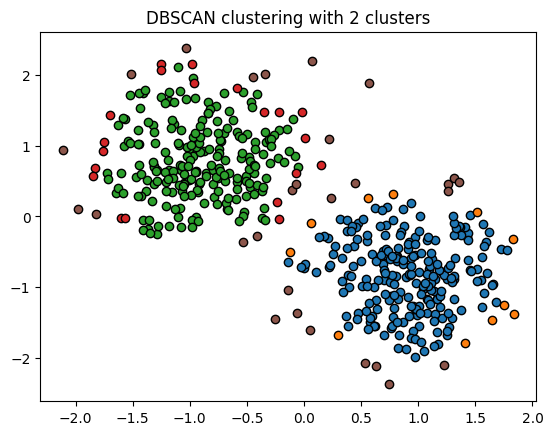

In [9]:

# Generating sample data
X, _ = make_moons(n_samples=300, noise=0.1, random_state=42)

path = os.path.join(OUTPUT_FOLDER, "kmeans_gaussian_df.csv")	
df = pd.read_csv(path)

X = df[[df.columns[0], df.columns[1]]].values
X_scaled = StandardScaler().fit_transform(X)  # Scaling is important for DBSCAN

    
db = run_dbscan(X_scaled)
if db:
    labels = db.labels_
    unique_labels = set(labels)
    
    # Plotting results
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    for k in unique_labels:
        class_member_mask = (labels == k)
        
        xy = X_scaled[class_member_mask & core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markeredgecolor='k')
        
        xy = X_scaled[class_member_mask & ~core_samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markeredgecolor='k')
    
    plt.title('DBSCAN clustering with 2 clusters')
    plt.show()

    # save the results
    df["labels_dbscan"] = db.labels_

(500, 5)
Found the desired number of clusters: 2 at eps=0.22000000000000008


27-Apr-24 15:45:41 [DEBUG] locator: <matplotlib.ticker.AutoLocator object at 0x00000138125DF940>
c:\Users\hayk_\.conda\envs\thesis\lib\site-packages\matplotlib\transforms.py:2038: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  self._mtx[0, 2] += tx
c:\Users\hayk_\.conda\envs\thesis\lib\site-packages\matplotlib\transforms.py:2039: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  self._mtx[1, 2] += ty


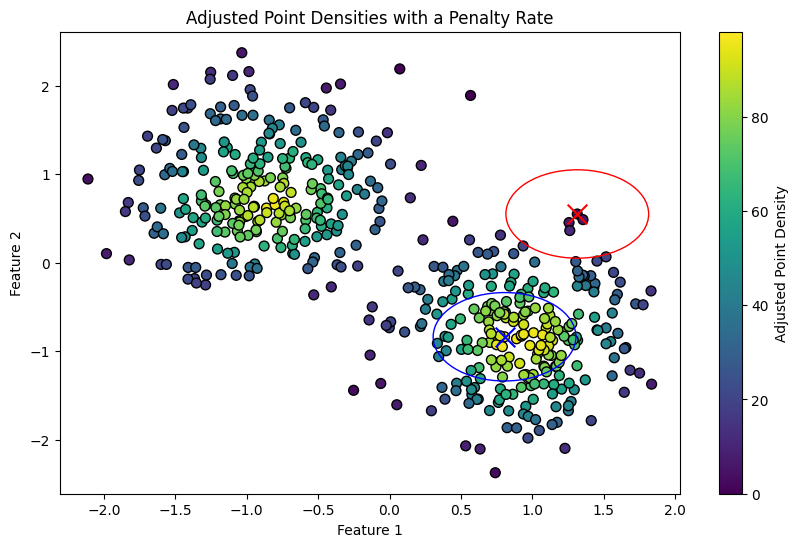

In [13]:



# Example data generation
# X, y = make_blobs(n_samples=200, centers=3, random_state=42, cluster_std=1.5)

# df = pd.DataFrame(X, columns=['Feature 1', 'Feature 2'])
# df['labels'] = y
OUTPUT_FOLDER = os.path.join("..", "data_binary_scaled")


path = os.path.join(OUTPUT_FOLDER, "kmeans_gaussian_df.csv")	
df = pd.read_csv(path)

X = df[[df.columns[0], df.columns[1]]].values
y = df["labels_clustering"].values

print(df.shape)
db = run_dbscan(X)

if db is None:
    logging.warning("Could not find the desired number of clusters.")
# Radius within which to count neighbors
radius = 0.5

# Calculate adjusted densities
adjusted_densities = calculate_adjusted_density(X, y, radius, penalty_rate=0.5, remove_outliers=False, normalize=False)

df["distance"] = adjusted_densities

outliers = detect_outliers_z_score(df["distance"])

df["outlier"] = df["distance"].apply(lambda x: x in outliers)

df_okay = df[~df["outlier"]]
df_okay = df
# normalize distance to centroid for each cluster
df["distance_norm"] = df_okay.groupby("labels_clustering")["distance"].transform(
    lambda x: (x - x.min()) / (x.max() - x.min()))

# df["distance_norm"] = (df["distance"] - df["distance"].min()) / (df["distance"].max() - df["distance"].min()) 


point_min = df[df["distance_norm"] == df["distance_norm"].min()].iloc[0]
point_min = pd.DataFrame(point_min).T
point_max = df[df["distance_norm"] == df["distance_norm"].max()].iloc[0]
point_max = pd.DataFrame(point_max).T
# Plotting
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X[:, 0], X[:, 1], c=adjusted_densities, cmap='viridis', edgecolor='k', s=50)

plt.colorbar(scatter, label='Adjusted Point Density')
plt.title('Adjusted Point Densities with a Penalty Rate')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')

# print("ok 2")
plt.scatter(point_min[point_min.columns[0]], point_min[point_min.columns[1]], c='red', s=200, marker='x', label='Min')
plt.scatter(point_max[point_max.columns[0]], point_max[point_max.columns[1]], c='blue', s=200, marker='x', label='Max')
# print("ok 3")
# plot circle if radius 2 around the point
circle_min = plt.Circle((point_min[point_min.columns[0]], point_min[point_min.columns[1]]), radius, color='red', fill=False)
circle_max = plt.Circle((point_max[point_max.columns[0]], point_max[point_max.columns[1]]), radius, color='blue', fill=False)
plt.gca().add_artist(circle_min)
plt.gca().add_artist(circle_max)
plt.show()

In [12]:
df["labels_dbscan"]

0      0
1      0
2      0
3      0
4      0
      ..
495    1
496    1
497    1
498    1
499    1
Name: labels_dbscan, Length: 500, dtype: int64

In [11]:
df["distance"].max()

98.0